In [1]:
import os
os.chdir("..")

In [2]:
from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords
import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [3]:
from skin_lesion_cad.data.BOVW import DenseDescriptor, ColorDescriptor, ColorFeaturesExtractorDescriptor, BagofWords
from skin_lesion_cad.features.colour import ColorFeaturesExtractorDescriptor


1. Test which K-means is faster (OpenCV, sklearn-intelx, sklearn, minibatch-sklearn)
2. Add Color Features Descriptor and extract features for the binary classification problem
3. Check which dense or dense+brick keypoints are better for the binary classification problem and 3class
4. Check if tf-idf is better than the simple histogram

In [5]:
SAMPLE_SIZE = 50

train_path = Path('data/raw/chall1/train')
training_names = train_path.rglob("*.jpg")

# Get path to all images and save them in a list
image_paths = random.sample([i for i in training_names], SAMPLE_SIZE)


# Currently only sampling few images for quick testing
image_paths = [i for i in training_names]
image_classes = [0 if ("nevus" in str(i)) else 1 for i in image_paths]
mask_paths = [Path(str(image_path.parent).replace("raw", "processed")) /
              Path(image_path.stem+"_mask_1_0.png") for image_path in image_paths]

images = [() for i in image_paths]
# BRISK is a good replacement to SIFT. ORB also works but didn;t work well for this example

brisk = cv2.BRISK_create(thresh=30, octaves=0)
dense_brisk = DenseDescriptor(descriptor=brisk, minKeypoints=20)


In [4]:
def _load_and_extract_des(image_path, mask_path, descriptor):
    im = cv2.imread(str(image_path))
    mask = cv2.imread(str(mask_path))
    kpts, des = descriptor.detectAndCompute(im, mask)
    return des

with parallel_backend('threading', n_jobs=-1):
    des_list = Parallel(verbose=10)(
        delayed(_load_and_extract_des)(filename, mask_paths[i], dense_brisk) for i, filename in enumerate(image_paths)
    )


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.1min


In [6]:
def _load_and_extract_des(image_path):
    img_class = 0 if ("nevus" in str(image_path)) else 1
    im = cv2.imread(str(image_path))
    mask = cv2.imread(str(image_path).replace('inpaint', 'mask'), cv2.IMREAD_GRAYSCALE)
    kpts, des = dense_brisk.detectAndCompute(im, mask)
    return des, img_class

In [7]:
des_list = []
img_labels = []
with mp.Pool(8) as pool:
    for (res, res_label) in tqdm(pool.imap(_load_and_extract_des, image_paths), total=len(image_paths)):
        des_list.append(res)
        img_labels.append(res_label)
        

100%|██████████| 50/50 [00:03<00:00, 13.42it/s]


(array([43.,  0.,  0.,  2.,  1.,  1.,  0.,  1.,  0.,  2.]),
 array([ 85. , 126.5, 168. , 209.5, 251. , 292.5, 334. , 375.5, 417. ,
        458.5, 500. ]),
 <BarContainer object of 10 artists>)

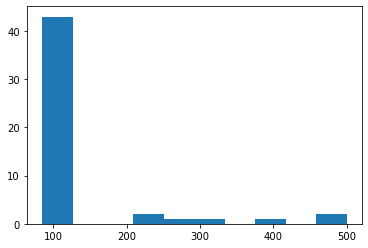

In [8]:
plt.hist([len(x) for x in des_list])

In [9]:
# pd.to_pickle((des_list, img_labels), 'data/processed/descriptors.pkl')
# des_list, img_labels = pd.read_pickle('data/processed/descriptors.pkl')

In [10]:
np.unique(img_labels, return_counts=True)

(array([0, 1]), array([27, 23]))

In [11]:
bovw = BagofWords(n_words=10, n_jobs=-1, random_state=None)
classifier = SVC(max_iter=10000)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(des_list, img_labels, test_size=0.33, random_state=42)

In [13]:
# X_train[np.isnan(X_train)] = 0
# X_train[np.isinf(X_train)] = 0

# X_test[np.isnan(X_test)] = 0
# X_test[np.isinf(X_test)] = 0


# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [14]:
X_train_preprocessed = bovw.fit_transform(X_train,y_train)
X_test_preprocessed = bovw.transform(X_test)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [15]:
classifier.fit(X_train_preprocessed,y_train)
y_pred = classifier.predict(X_test_preprocessed)

In [ ]:
print(classification_report(y_test, y_pred))
